---
Load Cancer Dataset

In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_digits

import matplotlib.pyplot as plt


cancer_ds = load_breast_cancer()
digits = load_digits()
data=cancer_ds

print("cancer.keys(): \n{}".format(cancer_ds.keys()))
print("Sample counts per class:\n{}".format({n: v for n, v in zip(cancer_ds.target_names, np.bincount(cancer_ds.target))}))

# Información del Dataset
cancer_ds.DESCR
cancer_ds.feature_names

# Data Frame
df = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= list(data['feature_names']) + ['target'])
df['target'] = df['target'].astype('uint16')
df.head()

cancer.keys(): 
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
Sample counts per class:
{'malignant': 212, 'benign': 357}


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Data Preprocessing
Let's remove unnecessary columns from the dataset.

In [2]:
#Espacio para preprocesamiento del dataset: eliminación de outliers, elimación datos faltantes,....

---
Particionar Data Set

In [3]:
from sklearn.model_selection import train_test_split

# Con Data Frame
#X = df.drop('target', axis=1)
#y = df[['target']]
# ó También sin Data Frame
#X= cancer_ds['data']
#y= cancer_ds['target']

X_train, X_test, y_train, y_test = train_test_split(cancer_ds['data'], cancer_ds['target'],
                  train_size=0.7, test_size=0.3, random_state=0, stratify=cancer_ds['target'], shuffle=True)
                  # El parámetro stratify asegura la partición balanceada

# X es una matriz, y es un vector
print("X_train shape: {}".format(X_train.shape))  
#print("y_train :", y_train)
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (398, 30)
y_train shape: (398,)
X_test shape: (171, 30)
y_test shape: (171,)


---
Decision Tree Classifier

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# base estimator: a weak learner with max_depth=2
shallow_tree = DecisionTreeClassifier(max_depth=2, random_state = 100)

# fit the shallow decision tree 
shallow_tree.fit(X_train, y_train)

# test error


y_pred_train = shallow_tree.predict(X_train)
score1 = metrics.accuracy_score(y_train, y_pred_train)


y_pred_test = shallow_tree.predict(X_test)
score2 = metrics.accuracy_score(y_test, y_pred_test)

print(f"Accuracy Train:',{score1: .3f}, 'Accuracy Test',{score2: .3f}")


Accuracy Train:', 0.942, 'Accuracy Test', 0.906


___
AdaBoost: Cross validation to select the best learning rate
---
learning_rate:  float, default=1.0

algorithm: {‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’



In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold

#Sets up stratified 10-fold CV and initializes the search space
n_learning_rate_steps, n_folds = 10, 10

learning_rates = np.linspace(0.1, 1.0, num=n_learning_rate_steps) 

splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)
trn_err = np.zeros((n_learning_rate_steps, n_folds))
val_err = np.zeros((n_learning_rate_steps, n_folds))

# Modelo base débil: árbol de un nivel
stump1 = DecisionTreeClassifier(max_depth=1) 


for i, rate in enumerate(learning_rates):   #For all choices of learning rates
   
   #For training, validation sets
   for j, (trn, val) in enumerate(splitter.split(X_train, y_train)):

         model = AdaBoostClassifier(algorithm='SAMME', estimator=stump1,
                            n_estimators=10, learning_rate=rate)
         model.fit(X_train[trn, :], y_train[trn]) ####
         # calcular errores par entrenamiento y validación
         trn_err[i, j] = 1 - metrics.accuracy_score(y_train[trn], model.predict(X_train[trn, :]))
         val_err[i, j] = 1 - metrics.accuracy_score(y_train[val], model.predict(X_train[val, :]))                                  
# Error Promedio         
trn_err_av1 = np.mean(trn_err, axis=1) 
val_err_av1 = np.mean(val_err, axis=1)       

___
Plot: Error Average vs Learnig Rate for training and validation dataset

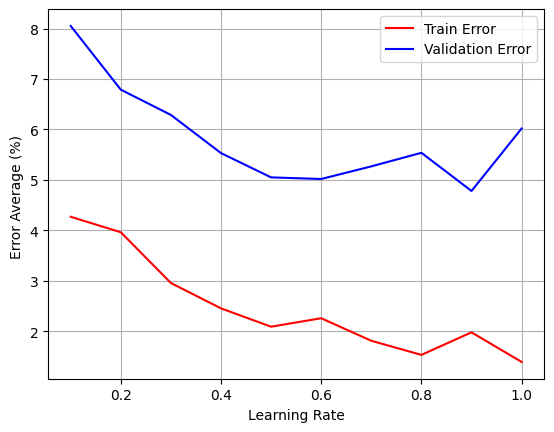

In [9]:
plt.plot(learning_rates, trn_err_av1*100, 'r',learning_rates, val_err_av1*100,'b' )
plt.xlabel('Learning Rate')
plt.ylabel('Error Average (%) ')
#plt.ylim([0.85, 1])
plt.legend({'Train Error', 'Validation Error'})
plt.grid()
plt.show()

___
AdaBoost: Cross validation to select the best number of weak learners
---

In [14]:
n_estimator_steps, n_folds = 5, 10
#Sets up stratified 10-fold CV and initializes the search space
number_of_stumps = np.arange(5, 50, n_estimator_steps) 
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)

trn_err = np.zeros((len(number_of_stumps), n_folds))
val_err = np.zeros((len(number_of_stumps), n_folds))

stump2 = DecisionTreeClassifier(max_depth=1)

for i, n_stumps in enumerate(number_of_stumps):  # cantidad de estimadores base débiles: stump
  for j, (trn, val) in enumerate(splitter.split(X_train, y_train)):  # validation sets
    model = AdaBoostClassifier(algorithm='SAMME', estimator=stump2,
    n_estimators=n_stumps, learning_rate=1.0)
    
    #Fits a model to training data in this fold
    model.fit(X_train[trn, :], y_train[trn]) 
    
    # calcular errores par entrenamiento y validación
    trn_err[i, j] = 1 - metrics.accuracy_score( y_train[trn], model.predict(X_train[trn, :]))
    val_err[i, j] = 1 - metrics.accuracy_score( y_train[val], model.predict(X_train[val, :]))

# Error Promedio
trn_err_av2 = np.mean(trn_err, axis=1)
val_err_av2 = np.mean(val_err, axis=1) 

---
Plot: Error Average vs Number of learning for training and validation dataset

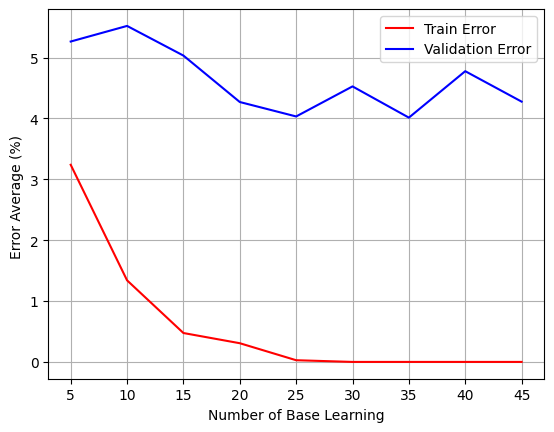

In [13]:
plt.plot(number_of_stumps, trn_err_av2*100, 'r',number_of_stumps, val_err_av2*100,'b' )
plt.xlabel('Number of Base Learning')
plt.ylabel('Error Average (%) ')
#plt.ylim([0.85, 1])
plt.legend({'Train Error', 'Validation Error'})
plt.grid()
plt.show()

___
Obtener un clasificador AdaBoost con los mejores valores de la tasa de aprendizaje y del número de aprendices base.
---


Verificar cual parámetro consigue mejor desempeño:

algorithm: por {‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

